In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os

In [186]:

# get file from parent directory
os.getcwd()
dir_path = os.getcwd() + "\.."
data = pd.read_csv(dir_path + '\census_bike_merged.csv')
data.head()

,tract,year,neighborhood,total_population,male,female,median_age,race_white,race_black,race_ai_alaskan,...,renters_owners_pre-2000_ratio,BFBL,BL,BLSL,SBL,SLM,SLMTC,SUP,total_built_all_lanes,cumulative_length
0,1001.00,2010,Dorchester,5617.00,0.48,0.52,23.90,0.06,0.64,0.01,...,0.70,0.00,2493.82,0.00,0.00,563.19,0.00,0.00,3057.01,3167.05
1,1001.00,2011,Dorchester,5657.00,0.48,0.52,24.50,0.11,0.62,0.01,...,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3167.05
2,1001.00,2012,Dorchester,6189.00,0.45,0.55,25.20,0.07,0.70,0.00,...,1.26,0.00,851.78,0.00,0.00,684.14,0.00,0.00,1535.92,4702.97
3,1001.00,2013,Dorchester,6295.00,0.43,0.57,27.30,0.11,0.73,0.00,...,1.24,0.00,36.45,0.00,0.00,0.00,0.00,0.00,36.45,4739.42
4,1001.00,2014,Dorchester,6371.00,0.46,0.55,31.20,0.13,0.75,0.00,...,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4739.42


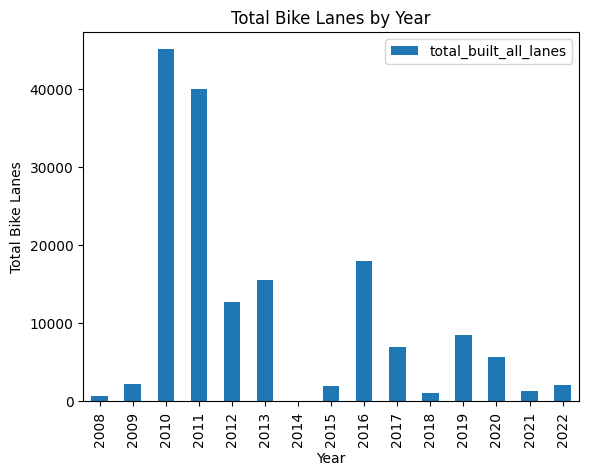

In [118]:
# checking for years with major changes in bike lanes
data = data.loc[data['neighborhood'].isin(['Dorchester', 'Roxbury'])]
data[['year', 'total_built_all_lanes']].groupby('year').sum().plot(kind='bar')
plt.title('Total Bike Lanes by Year')
plt.xlabel('Year')
plt.ylabel('Total Bike Lanes')
plt.show()

In [119]:
target_vars = ['median_monthly_rent', 'median_value', 'race_white', 'median_age', 'mean_income', 'median_income']
target_var_names = ['Median Monthly Rent', 'Median House Value', 'Percent White', 'Median Age', 'Mean Income', 'Median Income']

In [120]:
# add a 'previous years built' columns for 'total_built_all_lanes'
data['previous_1y_built_all_lanes'] = data['total_built_all_lanes'].shift(1)
data['previous_2y_built_all_lanes'] = data['total_built_all_lanes'].shift(2)
data['previous_3y_built_all_lanes'] = data['total_built_all_lanes'].shift(3)
data['previous_4y_built_all_lanes'] = data['total_built_all_lanes'].shift(4)
data['previous_5y_built_all_lanes'] = data['total_built_all_lanes'].shift(5)

possible settings:
1. binary (added bike lanes > 0) vs ordinal (levels of added bike lanes); continuos might be too complicated
2. single year change (fewer observations, more interpretable) vs all years

#### binary DiD: single year, binary treatment

##### 2010

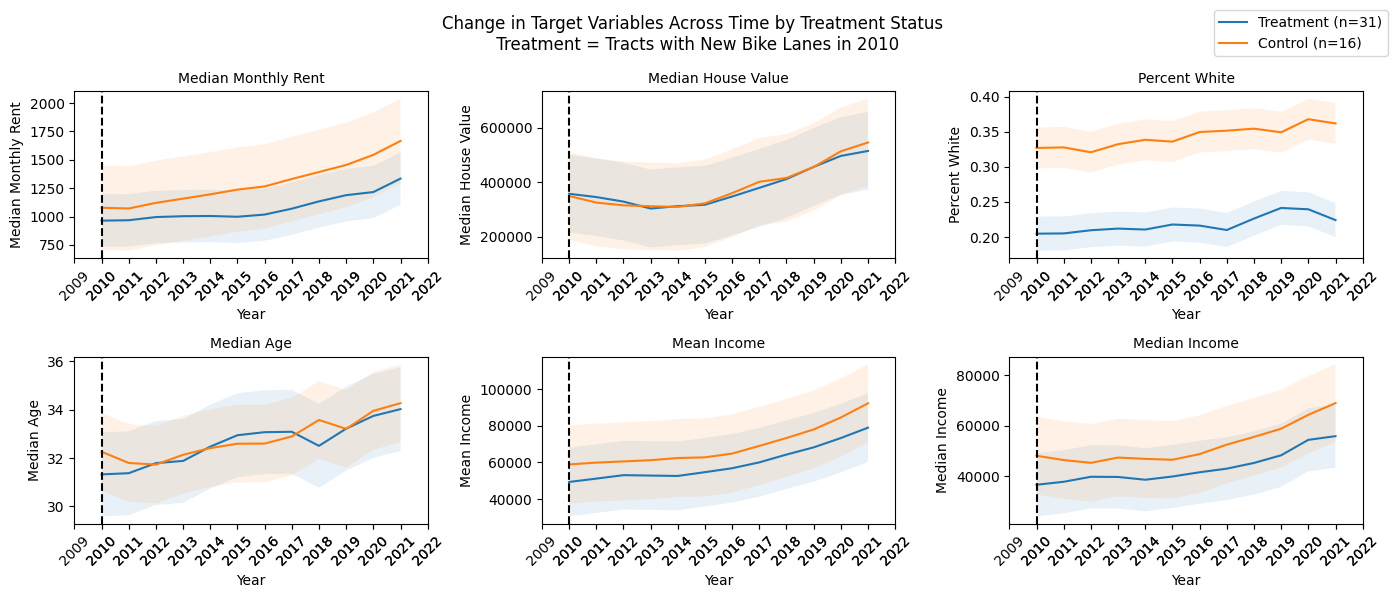

In [187]:
reg_2010 = data.copy(deep=True)

# create a treatment column to be 1 for all tracts for which 2010 had positive bike addition

# first, identify the tracts that had positive bike addition in 2010
treat_tracts = reg_2010[(reg_2010['total_built_all_lanes'] > 0)&(reg_2010['year']==2010)]['tract'].unique()
# create a treatment column that is 1 for all tracts that had positive bike addition in 2010
reg_2010['treatment'] = np.where(reg_2010['tract'].isin(treat_tracts), 1, 0)
n_control = reg_2010.loc[reg_2010['treatment']==0]['tract'].nunique()
n_treatment = reg_2010.loc[reg_2010['treatment']==1]['tract'].nunique()
#create subplots - number varies by len(target_vars):
cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = reg_2010.groupby(['year','treatment'])[var].mean().reset_index()
    treatment = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2010
    ax[i // 3, i %3].plot(treatment['year'], treatment[var], label=f'Treatment (n={n_treatment})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(treatment['year'], treatment[var] - 1.96*treatment[var].std(), treatment[var] + 1.96*treatment[var].std(), alpha=0.1)
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control (n={n_control})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)
    ax[i // 3, i %3].axvline(x=2010, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment = Tracts with New Bike Lanes in 2010')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()

In [206]:
# Run the DiD model
pd.options.display.float_format = '{:.2f}'.format
import statsmodels.formula.api as smf
# add 'post_treatment' column to indicate whether the year is after the treatment year
# reg_2010['post_treatment'] = np.where(reg_2010['year']>=2017, 1, 0)
#filter reg_2010 for only 5 years before and after treatment
reg_2010 = reg_2010[(reg_2010['year']>=2011)&(reg_2010['year']<=2017)]
targets = ['median_income', 'median_value', 'median_monthly_rent', 'race_white', 'renters_owners_ratio']
for var in targets:
    model = smf.ols(f'{var} ~ treatment*year + C(tract) ', data=reg_2010).fit()

    #show the summary and exclude the tract variables because there are too many
    table = pd.DataFrame(model.summary2().tables[1])
    # show full numbers instead of scientific notation
    print()
    print(var)
    print(f'N = {len(reg_2010)}')
    print(f'R2 = {model.rsquared:.2f}')
    print(table.iloc[-3:, :3])
    coeff = model.params['treatment:year']
    pval = model.pvalues['treatment:year']
    print(f'Treatment Variable has a coefficient of {coeff: .2f} and a p-value of {pval: .2f}')



median_income
N = 329
R2 = 0.92
                   Coef.  Std.Err.     t
treatment      360906.58 581119.44  0.62
year              872.44    241.89  3.61
treatment:year   -180.87    297.85 -0.61
Treatment Variable has a coefficient of -180.87 and a p-value of  0.54

median_value
N = 329
R2 = 0.52
                     Coef.   Std.Err.     t
treatment      12300397.84 5167268.56  2.38
year              11752.38    2174.15  5.41
treatment:year    -6290.75    2648.42 -2.38
Treatment Variable has a coefficient of -6290.75 and a p-value of  0.02

median_monthly_rent
N = 329
R2 = 0.90
                  Coef.  Std.Err.     t
treatment      56033.82  11481.20  4.88
year              41.02      4.78  8.58
treatment:year   -28.70      5.88 -4.88
Treatment Variable has a coefficient of -28.70 and a p-value of  0.00

race_white
N = 329
R2 = 0.99
                Coef.  Std.Err.     t
treatment        6.93      3.33  2.08
year             0.00      0.00  3.43
treatment:year  -0.00      0.00 -2.08
T

##### 2016

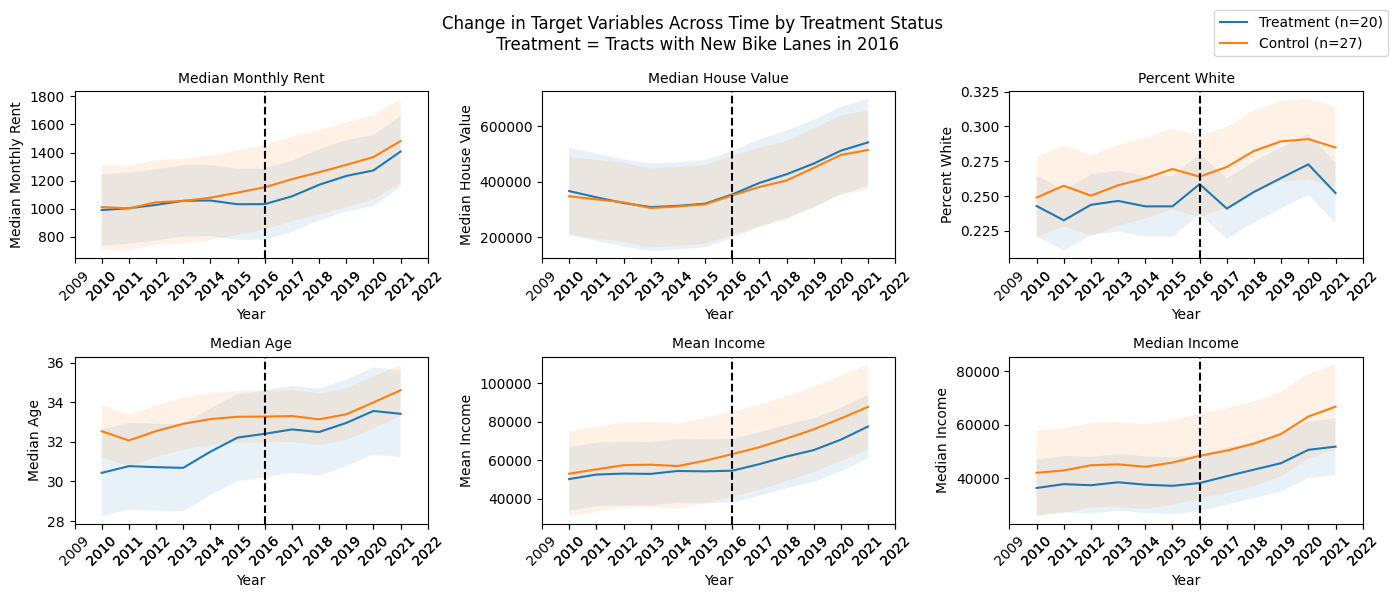

In [188]:
reg_2016 = data.copy(deep=True)
# create a treatment column to be 1 for all tracts for which 2016 had positive bike addition

# first, identify the tracts that had positive bike addition in 2016
treat_tracts = reg_2016[(reg_2016['total_built_all_lanes'] > 0)&(reg_2016['year']==2016)]['tract'].unique()
# create a treatment column that is 1 for all tracts that had positive bike addition in 2016
reg_2016['treatment'] = np.where(reg_2016['tract'].isin(treat_tracts), 1, 0)
n_control = reg_2016.loc[reg_2016['treatment']==0]['tract'].nunique()
n_treatment = reg_2016.loc[reg_2016['treatment']==1]['tract'].nunique()
#create subplots - number varies by len(target_vars):
cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = reg_2016.groupby(['year','treatment'])[var].mean().reset_index()
    treatment = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2016
    ax[i // 3, i %3].plot(treatment['year'], treatment[var], label=f'Treatment (n={n_treatment})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(treatment['year'], treatment[var] - 1.96*treatment[var].std(), treatment[var] + 1.96*treatment[var].std(), alpha=0.1)
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control (n={n_control})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)
    ax[i // 3, i %3].axvline(x=2016, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment = Tracts with New Bike Lanes in 2016')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()

In [133]:
data.columns

Index(['tract', 'year', 'neighborhood', 'total_population', 'male', 'female',
       'median_age', 'race_white', 'race_black', 'race_ai_alaskan',
       'race_asian', 'race_hawaiian', 'race_other', 'race_hispanic',
       'median_value', 'median_monthly_mort', 'median_monthly_rent',
       'median_income', 'mean_income', 'housed_population', 'owner_occupied',
       'owner_occupied_pre-2000', 'renter_occupied',
       'renter_occupied_pre-2000', 'percent_owners', 'percent_renters',
       'percent_owners_pre-2000', 'percent_renters_pre-2000',
       'renters_owners_ratio', 'renters_owners_pre-2000_ratio', 'BFBL', 'BL',
       'BLSL', 'SBL', 'SLM', 'SLMTC', 'SUP', 'total_built_all_lanes',
       'cumulative_length', 'previous_1y_built_all_lanes',
       'previous_2y_built_all_lanes', 'previous_3y_built_all_lanes',
       'previous_4y_built_all_lanes', 'previous_5y_built_all_lanes'],
      dtype='object')

In [202]:
# Run the DiD model
pd.options.display.float_format = '{:.2f}'.format
import statsmodels.formula.api as smf
# add 'post_treatment' column to indicate whether the year is after the treatment year
reg_2016['post_treatment'] = np.where(reg_2016['year']>=2017, 1, 0)
#filter reg_2016 for only 5 years before and after treatment
reg_2016 = reg_2016[(reg_2016['year']>=2011)&(reg_2016['year']<=2021)]
targets = ['median_income', 'median_value', 'median_monthly_rent', 'race_white', 'renters_owners_ratio']
for var in targets:
    model = smf.ols(f'{var} ~ treatment*post_treatment*year + C(tract) ', data=reg_2016).fit()

    #show the summary and exclude the tract variables because there are too many
    table = pd.DataFrame(model.summary2().tables[1])
    # show full numbers instead of scientific notation
    print()
    print(var)
    print(f'N = {len(reg_2016)}')
    print(f'R2 = {model.rsquared:.2f}')
    print(table.iloc[-7:, :3])
    coeff = model.params['treatment:post_treatment']
    pval = model.pvalues['treatment:post_treatment']
    print(f'Treatment Interaction Variable has a coefficient of {coeff: .2f} and a p-value of {pval: .2f}')



median_income
N = 517
R2 = 0.90
                                    Coef.   Std.Err.     t
treatment                      1588615.73  986061.30  1.61
post_treatment                -6942030.27 1121964.95 -6.19
treatment:post_treatment       1269489.03 1721688.02  0.74
year                               836.98     335.43  2.50
treatment:year                    -823.53     514.21 -1.60
post_treatment:year               3442.33     556.25  6.19
treatment:post_treatment:year     -628.64     853.59 -0.74
Treatment Interaction Variable has a coefficient of  1269489.03 and a p-value of  0.46

median_value
N = 517
R2 = 0.77
                                     Coef.    Std.Err.     t
treatment                        374327.83  6912603.69  0.05
post_treatment                -69858865.33  7778628.76 -8.98
treatment:post_treatment       -2402977.33 12188930.56 -0.20
year                               1558.84     2322.54  0.67
treatment:year                     -200.64     3613.81 -0.06
post_treat

#### Ordinal Treatment: single year, different level treatment

##### 2010

<Axes: >

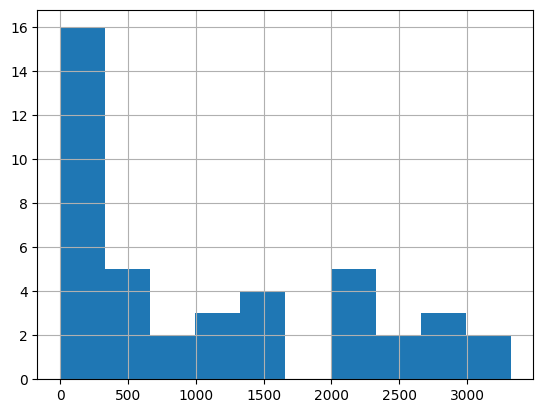

In [127]:
data[data['year']==2010]['total_built_all_lanes'].hist(bins=10)

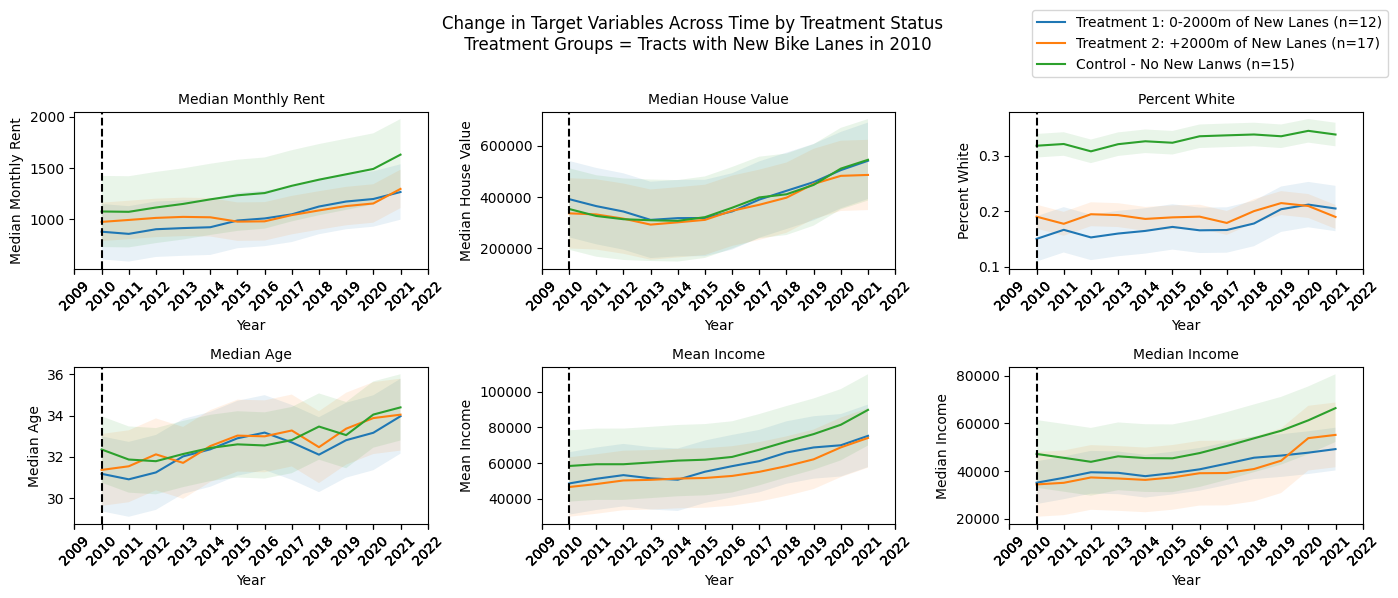

In [128]:
plot_df = data.copy(deep=True)
# create 2 treatment columns for all tracts for which 2010 had positive bike addition: 1 for <2000 and 2 for >=2000

# first, identify the tracts that had positive bike addition in 2010
treat2_tracts = plot_df[(plot_df['total_built_all_lanes'] > 0)&(plot_df['total_built_all_lanes'] <2000)&(plot_df['year']==2010)]['tract'].unique()
treat1_tracts = plot_df[(plot_df['total_built_all_lanes'] >= 2000)&(plot_df['year']==2010)]['tract'].unique()

# create a treatment column that is 1 for all tracts that had positive bike addition in 2010
conditions = [
    plot_df['tract'].isin(treat1_tracts),
    plot_df['tract'].isin(treat2_tracts)
]

choices = [1, 2]
plot_df['treatment'] = np.select(conditions, choices, default=0)
n_control = plot_df.loc[plot_df['treatment']==0]['tract'].nunique()
n_treatment1 = plot_df.loc[plot_df['treatment']==1]['tract'].nunique()
n_treatment2 = plot_df.loc[plot_df['treatment']==2]['tract'].nunique()

cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = plot_df.groupby(['year','treatment'])[var].mean().reset_index()
    treatment2 = target_var_df[target_var_df['treatment'] == 2]
    treatment1 = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2010
    ax[i // 3, i %3].plot(treatment1['year'], treatment1[var], label=f'Treatment 1: 0-2000m of New Lanes (n={n_treatment1})')
    ax[i // 3, i %3].fill_between(treatment1['year'], treatment1[var] - 1.96*treatment1[var].std(), treatment1[var] + 1.96*treatment1[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(treatment2['year'], treatment2[var], label=f'Treatment 2: +2000m of New Lanes (n={n_treatment2})')
    ax[i // 3, i %3].fill_between(treatment2['year'], treatment2[var] - 1.96*treatment2[var].std(), treatment2[var] + 1.96*treatment2[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control - No New Lanws (n={n_control})')
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)

    ax[i // 3, i %3].axvline(x=2010, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment Groups = Tracts with New Bike Lanes in 2010\n')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()

##### 2016

<Axes: >

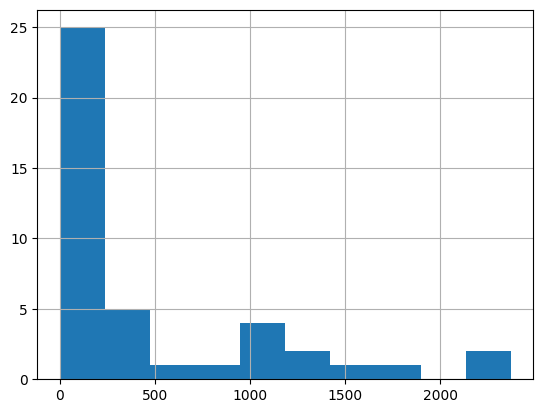

In [129]:
data[data['year']==2016]['total_built_all_lanes'].hist()

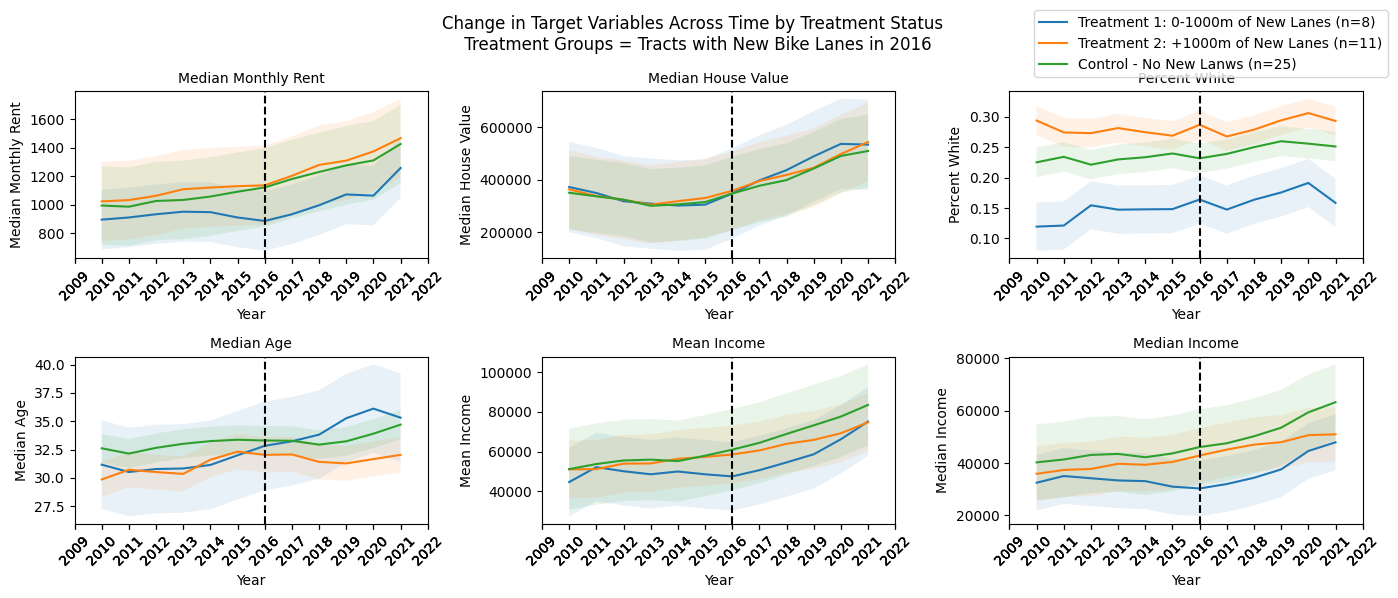

In [130]:
plot_df = data.copy(deep=True)

# create 2 treatment columns for all tracts for which 2016 had positive bike addition: 1 for <1000 and 2 for >=1000

# first, identify the tracts that had positive bike addition in 2016
treat2_tracts = plot_df[(plot_df['total_built_all_lanes'] > 0)&(plot_df['total_built_all_lanes'] <1000)&(plot_df['year']==2016)]['tract'].unique()
treat1_tracts = plot_df[(plot_df['total_built_all_lanes'] >= 1000)&(plot_df['year']==2016)]['tract'].unique()

# create a treatment column that is 1 for all tracts that had positive bike addition in 2016
conditions = [
    plot_df['tract'].isin(treat1_tracts),
    plot_df['tract'].isin(treat2_tracts)
]

choices = [1, 2]
plot_df['treatment'] = np.select(conditions, choices, default=0)
n_control = plot_df.loc[plot_df['treatment']==0]['tract'].nunique()
n_treatment1 = plot_df.loc[plot_df['treatment']==1]['tract'].nunique()
n_treatment2 = plot_df.loc[plot_df['treatment']==2]['tract'].nunique()

cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = plot_df.groupby(['year','treatment'])[var].mean().reset_index()
    treatment2 = target_var_df[target_var_df['treatment'] == 2]
    treatment1 = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2016
    ax[i // 3, i %3].plot(treatment1['year'], treatment1[var], label=f'Treatment 1: 0-1000m of New Lanes (n={n_treatment1})')
    ax[i // 3, i %3].fill_between(treatment1['year'], treatment1[var] - 1.96*treatment1[var].std(), treatment1[var] + 1.96*treatment1[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(treatment2['year'], treatment2[var], label=f'Treatment 2: +1000m of New Lanes (n={n_treatment2})')
    ax[i // 3, i %3].fill_between(treatment2['year'], treatment2[var] - 1.96*treatment2[var].std(), treatment2[var] + 1.96*treatment2[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control - No New Lanws (n={n_control})')
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)

    ax[i // 3, i %3].axvline(x=2016, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment Groups = Tracts with New Bike Lanes in 2016')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()